In [20]:
import matplotlib.pyplot as plt
from helpers.cm26 import DatasetCM26, operator_Kochkov
from helpers.computational_tools import select_NA, select_Pacific, select_Cem, select_Equator, StateFunctions, compare
from helpers.ann_tools import ANN, import_ANN, minibatch, export_ANN
import torch
import torch.optim as optim
import numpy as np
from time import time
import json
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ds = DatasetCM26()

In [3]:
ann_Txy = ANN([27, 20, 1])
ann_Txx_Tyy = ANN([27, 20, 2])
log_dict = {}
# ann_Txy = import_ANN('trained_models/ANN_Txy_ZB.nc')
# ann_Txx_Tyy = import_ANN('trained_models/ANN_Txx_Tyy_ZB.nc')

In [4]:
num_epochs=2000

all_parameters = list(ann_Txy.parameters()) + list(ann_Txx_Tyy.parameters())
optimizer = optim.Adam(all_parameters, lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
        milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)  

t_s = time()

for epoch in range(num_epochs):
    t_e = time()
    
    training_dataset = ds.sample_epoch(time=np.random.randint(6950), operator=operator_Kochkov) # Approximately 19 years for training
    testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035), operator=operator_Kochkov) # Approximately 3 years for testing
    print(f'---------- Epoch {epoch} ------------\n')
    
    for factor in [2,4,6,10,20]:
        ############# Training step ################
        
        optimizer.zero_grad()
        
        batch = training_dataset[factor]
        prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)
        ANNx = prediction['ZB20u']
        ANNy = prediction['ZB20v']
        SGSx = torch.tensor(batch.data.SGSx.values).type(torch.float32)
        SGSy = torch.tensor(batch.data.SGSy.values).type(torch.float32)
        
        SGS_norm = 1. / torch.sqrt((SGSx**2 + SGSy**2).mean())
        
        MSE_train = ((ANNx*SGS_norm-SGSx*SGS_norm)**2 + (ANNy*SGS_norm-SGSy*SGS_norm)**2).mean()
        
        MSE_train.backward()
        optimizer.step()
        
        ############ Testing step ##################
        with torch.no_grad():
            batch = testing_dataset[factor]
            prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)
            ANNx = prediction['ZB20u']
            ANNy = prediction['ZB20v']
            SGSx = torch.tensor(batch.data.SGSx.values).type(torch.float32)
            SGSy = torch.tensor(batch.data.SGSy.values).type(torch.float32)

            SGS_norm = 1. / torch.sqrt((SGSx**2 + SGSy**2).mean())

            MSE_test = ((ANNx*SGS_norm-SGSx*SGS_norm)**2 + (ANNy*SGS_norm-SGSy*SGS_norm)**2).mean()
        
        print(f'Factor: {factor}. '+'MSE train/test: [%.6f, %.6f]' % (float(MSE_train.data), float(MSE_test.data)))
        ########### Saving history of losses ############
        log_dict[f'epoch-{epoch+1}-factor-{factor}'] = dict(MSE_train=float(MSE_train.data),MSE_test=float(MSE_test.data))
        ######## Freeing memory ############
        del training_dataset[factor].data
        del training_dataset[factor].param
        del testing_dataset[factor].data
        del testing_dataset[factor].param
    t = time()
    print('Epoch time/Remaining time in seconds: [%d/%d]' % (t-t_e, (t-t_s)*(num_epochs/(epoch+1)-1)))
    scheduler.step()
    
    if (epoch+1) % 50 == 0:
        export_ANN(ann_Txy, input_norms=torch.ones(27), output_norms=torch.ones(1), 
           filename=f'trained_models/ANN_CM26_Kochkov/Txy_epoch_{epoch+1}.nc')
        export_ANN(ann_Txx_Tyy, input_norms=torch.ones(27), output_norms=torch.ones(2), 
           filename=f'trained_models/ANN_CM26_Kochkov/Txx_Tyy_epoch_{epoch+1}.nc')
        with open(f'trained_models/ANN_CM26_Kochkov/log_dict_epoch_{epoch+1}', 'w') as file:
            json.dump(log_dict, file)

---------- Epoch 0 ------------

Factor: 2. MSE train/test: [22.428392, 18.913210]
Factor: 4. MSE train/test: [13.707043, 12.250734]
Factor: 6. MSE train/test: [9.695134, 9.683377]
Factor: 10. MSE train/test: [5.819926, 5.352421]
Factor: 20. MSE train/test: [2.740386, 2.580610]
Epoch time/Remaining time in seconds: [16/33235]
---------- Epoch 1 ------------

Factor: 2. MSE train/test: [17.341208, 16.092649]
Factor: 4. MSE train/test: [9.535474, 8.451037]
Factor: 6. MSE train/test: [6.896244, 6.905601]
Factor: 10. MSE train/test: [4.430771, 3.856791]
Factor: 20. MSE train/test: [2.020891, 1.863858]
Epoch time/Remaining time in seconds: [15/32093]
---------- Epoch 2 ------------

Factor: 2. MSE train/test: [11.421391, 11.430476]
Factor: 4. MSE train/test: [7.218944, 7.135263]
Factor: 6. MSE train/test: [5.276933, 5.057386]
Factor: 10. MSE train/test: [3.256632, 3.270263]
Factor: 20. MSE train/test: [1.739944, 1.859520]
Epoch time/Remaining time in seconds: [15/31801]
---------- Epoch 3 -

(0.1, 1.2)

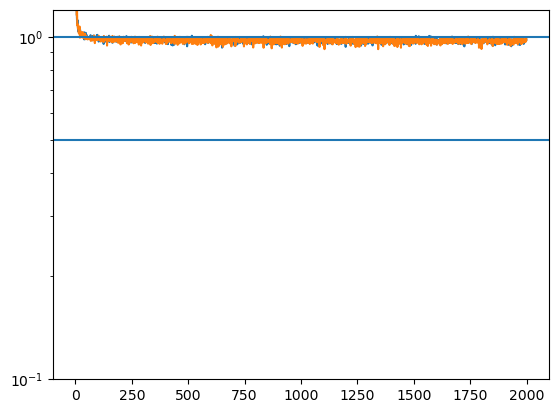

In [11]:
import json
import matplotlib.pyplot as plt

with open('trained_models/ANN_CM26_Kochkov/log_dict_epoch_2000') as f:
    data = json.load(f)
    
    plt.plot([data[f'epoch-{j}-factor-20']['MSE_train'] for j in range(1,2001)], label='Train')
plt.plot([data[f'epoch-{j}-factor-20']['MSE_test'] for j in range(1,2001)], label='Test')
plt.yscale('log')
plt.axhline(y=0.5)
plt.axhline(y=1.0)
plt.ylim([1e-1,1.2])

In [12]:
ann_Txy = import_ANN('trained_models/ANN_CM26_Kochkov/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_Kochkov/Txx_Tyy_epoch_2000.nc')

Correlation: 0.5432155416214581
Relative Error: 0.9294177981646421
R2 =  0.2675491109223537
R2 max =  0.29506908255296693
Optinal scaling: 0.7660515659953536
Nans [test/control]: [19185, 19185]
Correlation: 0.5027406066964255
Relative Error: 0.9418957678179646
R2 =  0.23361076546494397
R2 max =  0.25274431569356914
Optinal scaling: 0.7842263093487298
Nans [test/control]: [8787, 8787]
Correlation: 0.4280330294903107
Relative Error: 0.9687430801929098
R2 =  0.16212224556810173
R2 max =  0.18320940145843456
Optinal scaling: 0.7466799277771241
Nans [test/control]: [3494, 3494]


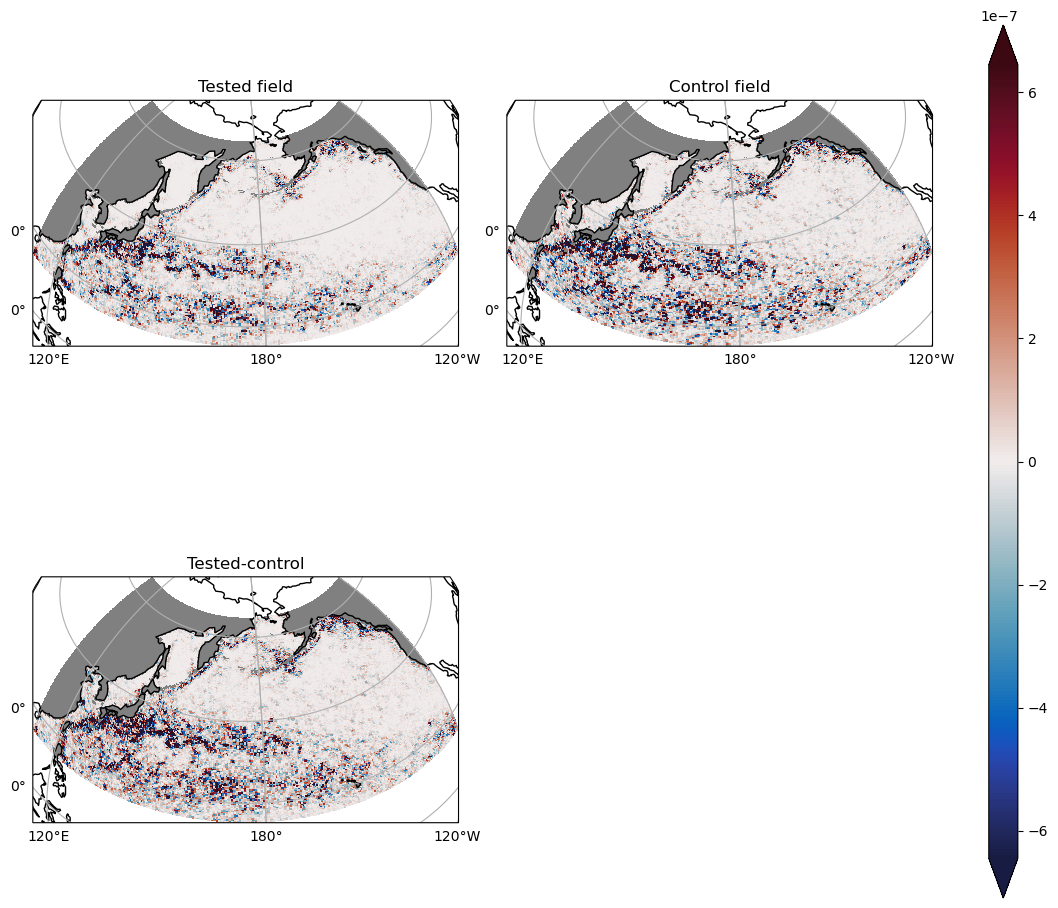

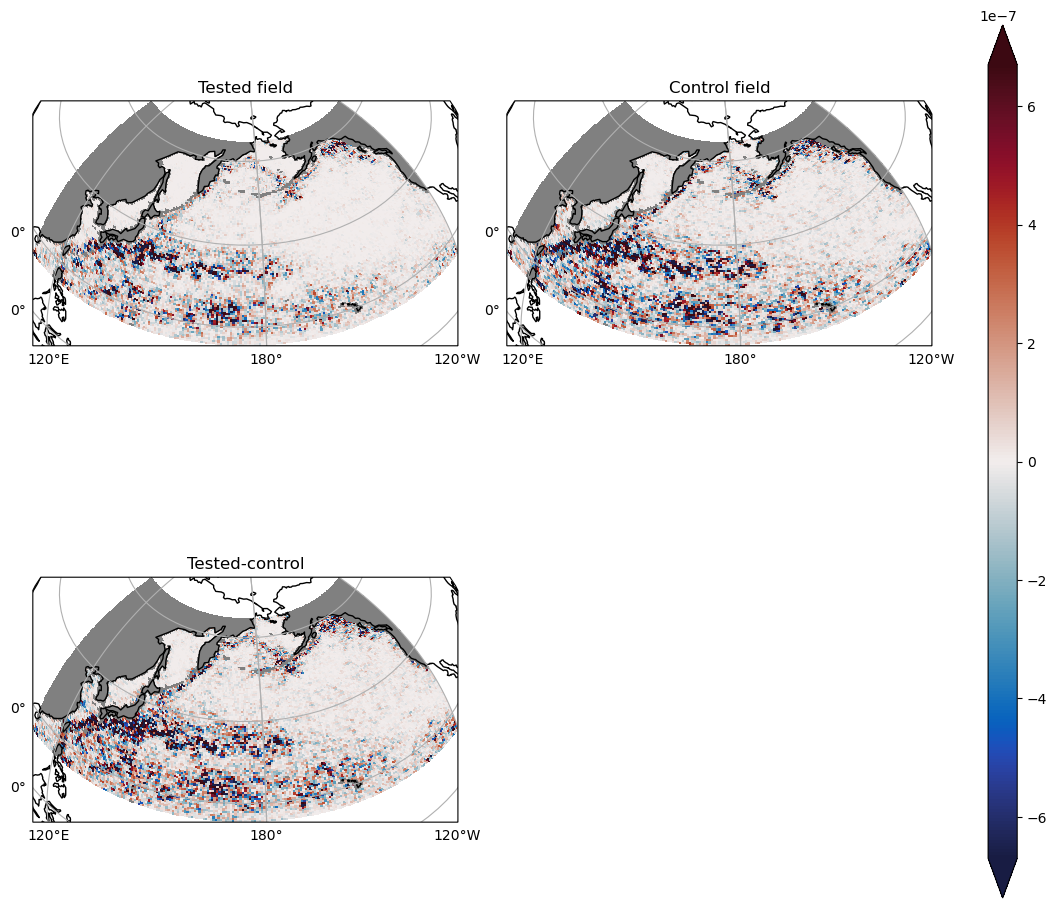

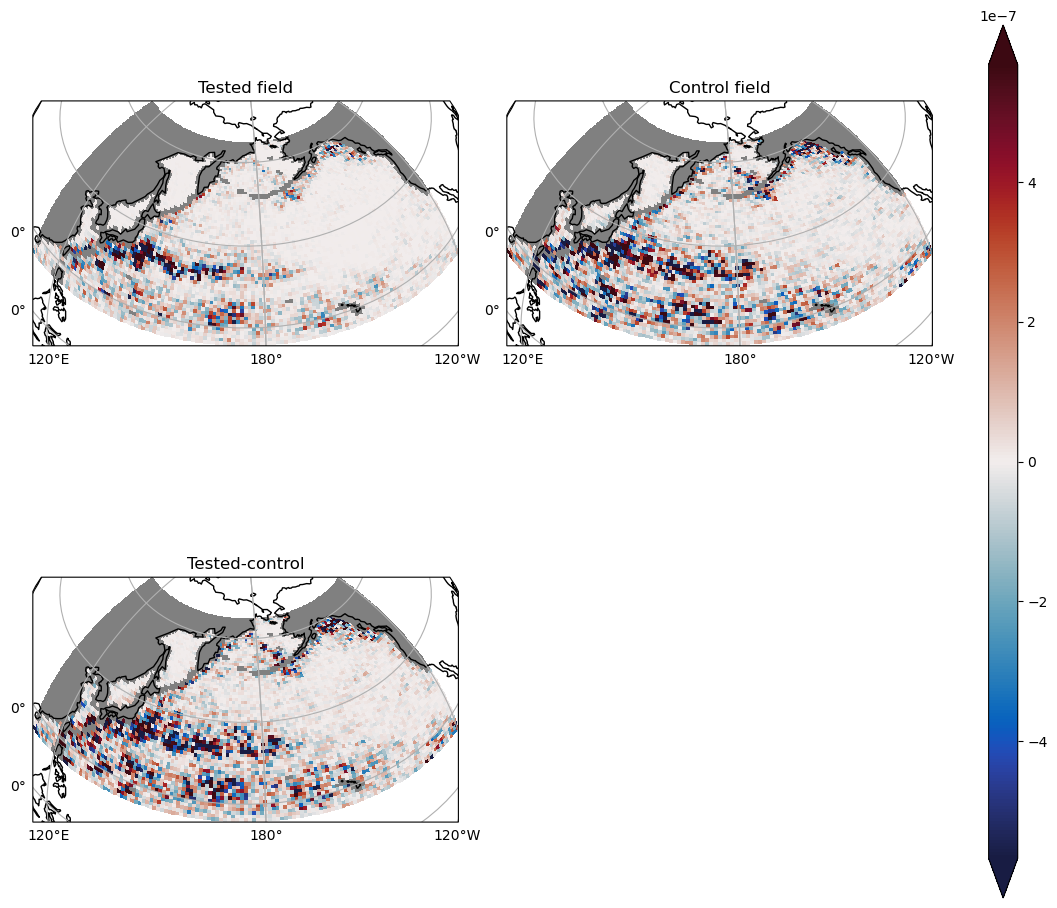

In [23]:
testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035))
for factor in [4,6,10]:
    data = testing_dataset[factor].data
    param = testing_dataset[factor].param
    state = testing_dataset[factor].state
    compare(state.ANN(ann_Txy, ann_Txx_Tyy)['ZB20u'], data.SGSx, param.wet_u, selector=select_Pacific)

Correlation: 0.493230525717257
Relative Error: 0.9278888636269509
R2 =  0.23762982552806378
R2 max =  0.2432444834074552
Optinal scaling: 0.8681091985174766
Nans [test/control]: [19149, 19149]
Correlation: 0.593853537698608
Relative Error: 0.9243310968934593
R2 =  0.34936975467122333
R2 max =  0.35255292002275074
Optinal scaling: 0.913224888495946
Nans [test/control]: [8855, 8855]
Correlation: 0.47309464358420567
Relative Error: 0.9739602445454313
R2 =  0.2134103986545629
R2 max =  0.2236083154008578
Optinal scaling: 0.8240246092711022
Nans [test/control]: [3369, 3369]


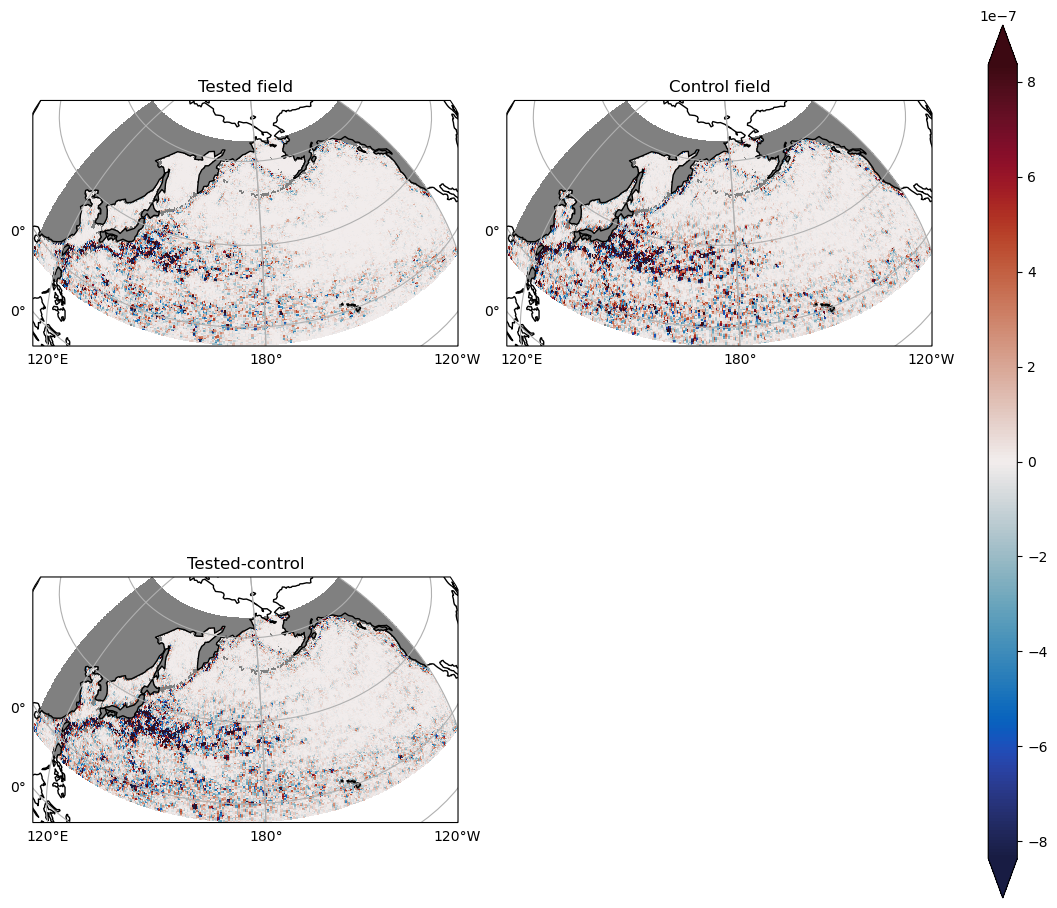

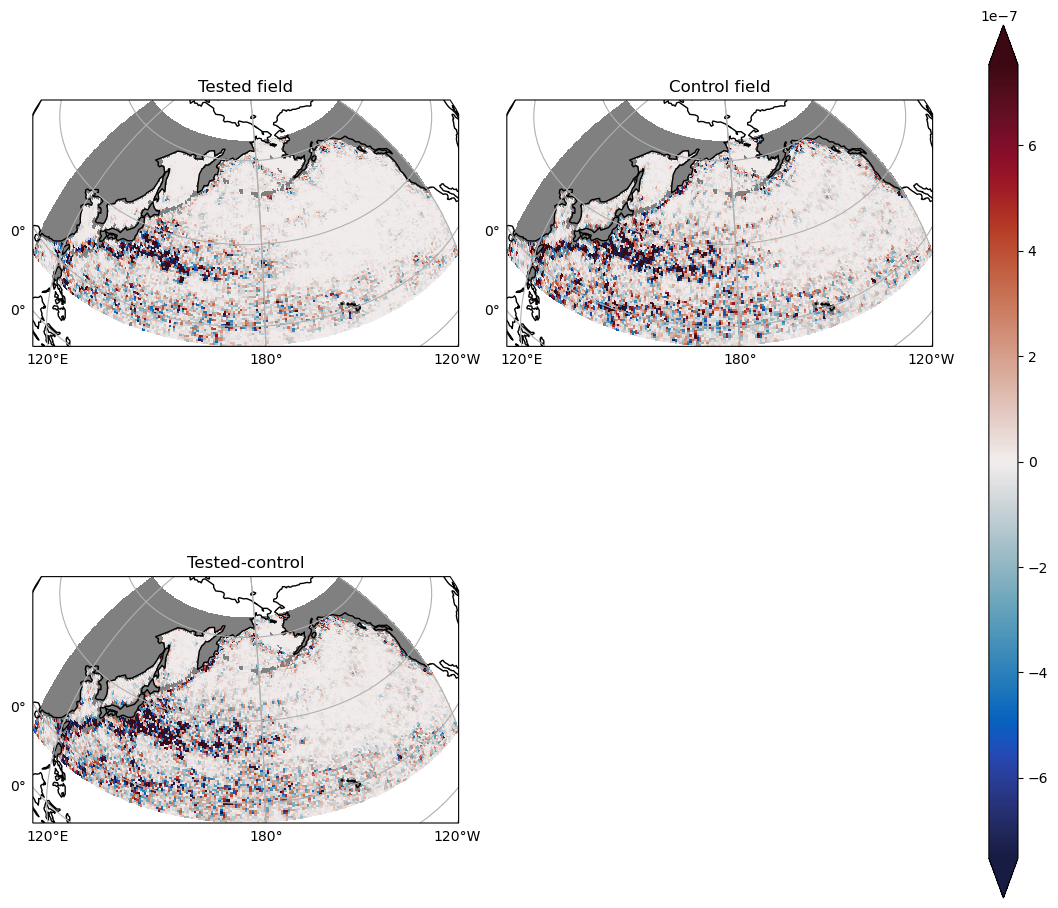

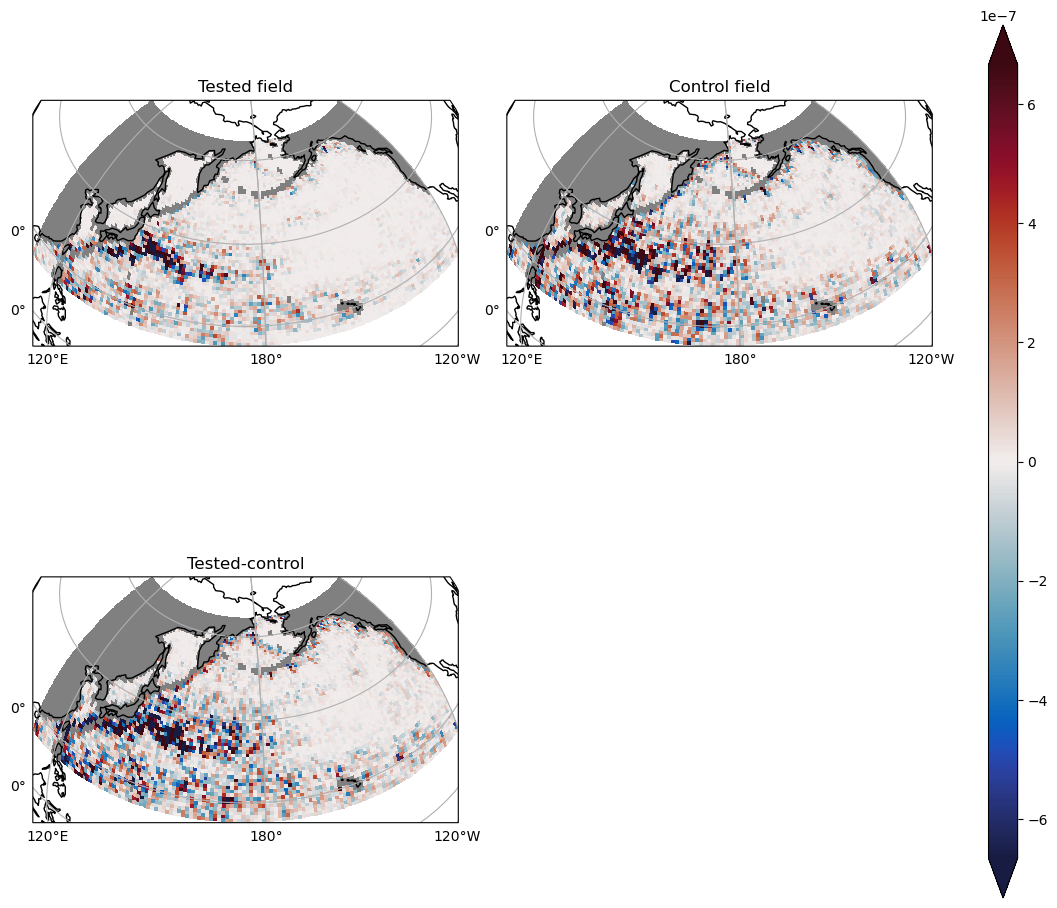

In [24]:
testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035))
for factor in [4,6,10]:
    data = testing_dataset[factor].data
    param = testing_dataset[factor].param
    state = testing_dataset[factor].state
    compare(state.ANN(ann_Txy, ann_Txx_Tyy)['ZB20v'], data.SGSy, param.wet_v, selector=select_Pacific)